In [1]:
import numpy as np
import torch
import os
from math import ceil
import copy
import matplotlib.pyplot as plt

# Define basic architectures
- fully connected networks
- - Fully Connected Networks are easy to scale up, we don't need to re-design the architecture
- TODO
- - In order to efficiently scale up convolutional neural networks, we determine to use efficentNet to scale up the networks

In [2]:
import torch
from torch import nn

class fc(nn.Module):  # only for mnist
  def __init__(self,n_layers,n_neurons,n_classes):
    super(fc, self).__init__()

    assert n_layers > 0, "layers must be positive integer"
    assert n_neurons > 0, "layers must be positive integer"

    layers = []
    layers.append(nn.Linear(28*28, n_neurons))  # first layer should match mnist image sizes
    layers.append(nn.ReLU())    # we can add BN and dropout layer here, TBD
    for i in range(n_layers-1):
      layers.append(nn.Linear(n_neurons,n_neurons))
      layers.append(nn.ReLU())  # we can add BN and dropout layer here, TBD
    layers.append(nn.Linear(n_neurons,n_classes))
    
    self.classifier = nn.Sequential(*layers)
  
  def forward(self,x):
    x = x.view(x.size(0),-1)  # reshape the input x
    y = self.classifier(x)
    return y

# specify a model with the specific hyperparameters
def specifyModel(model_type,args):
  assert model_type in ['fc','lenet','vgg']
  if model_type == 'fc':
    # fc args format should be (n_layers,n_neurons,n_classes)
    model = fc(*args)
  return model

# Utils
- initialize dataloader
- train function
- validate function
- store model weights


In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

def loadData(str_dataset):
  assert str_dataset in ['mnist','cifar10','fashionmnist']  # only implement mnist right now, TODO
  if str_dataset == 'mnist':
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    trainDataset = datasets.MNIST('./data/', train=True, download=True, transform=transform)
    testDataset = datasets.MNIST('./data/', train=False, transform=transform)
  return trainDataset, testDataset

def defLoader(train_dataset,test_dataset,batch_size):
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

In [4]:
from tqdm import tqdm
import torch

def train(model,train_loader,optimizer,criterion):
  EPS = 1e-8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()
  for batch_idx,(x,y) in enumerate(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    train_loss = criterion(pred,y)
    train_loss.backward()
    freeze_pruned_weight(EPS) # freeze pruned weights by making their gradients zero
    optimizer.step()
    if batch_idx%1000 == 0:
      print(f'Batch_idx={batch_idx}, training_loss={train_loss.item()/len(x)}')
  return train_loss.item()/len(x)

def trainWithScheduler(model,train_loader,optimizer,criterion,scheduler,log=False):
  EPS = 1e-8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()
  for batch_idx,(x,y) in enumerate(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    train_loss = criterion(pred,y)
    train_loss.backward()
    freeze_pruned_weight(EPS) # freeze pruned weights by making their gradients zero
    optimizer.step()
    scheduler.step()
    if batch_idx%1000 == 0 and log:
      print(f'Batch_idx={batch_idx}, training_loss={train_loss.item()/len(x)}')
  return train_loss.item()/len(x)

def validate(model,test_loader,criterion):
  validation_loss, correct = 0,0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()
  with torch.no_grad():
    for batch_idx, (x,y) in enumerate(test_loader):
      x, y = x.to(device), y.to(device)
      pred = model(x)
      validation_loss += criterion(pred,y).item()
      correct += (pred.argmax(1) == y).sum().item()
  test_size = len(test_loader.dataset)
  validation_loss /= test_size
  accuracy = correct/test_size
  return validation_loss, accuracy



In [5]:
import os
import torch

def store_content(rootPath,content,*args):
  rootPath = rootPath
  if not os.path.exists(rootPath):
    os.makedirs(rootPath)
  contentPath = ''
  contentPath = os.path.join(contentPath,rootPath)
  contentPath += args[0]
  for element in args[1:]:
    contentPath += '_'
    contentPath += str(element)
  contentPath += '.pth'
  print('storedPath:',contentPath)
  torch.save(content,contentPath)
  return contentPath

# Prune Methods
- layer_wise pruning
- TODO

In [6]:
def prune_layer_wise(prune_type,percent=20):
  global mask
  global model
  assert prune_type in ['percentile','l1']
  step = 0
  if prune_type == 'percentile':
    for name, param in model.named_parameters():
      if 'weight' in name:
        param_tensor = param.data.cpu().numpy()
        reserved_param = param_tensor[np.nonzero(param_tensor)] # only prune still-unpruned params
        percentile_value = np.percentile(abs(reserved_param), percent)

        weight_dev = param.device
        new_mask = np.where(abs(param_tensor) < percentile_value, 0, mask[step])  
        param.data = torch.from_numpy(param_tensor*new_mask).to(weight_dev)
        mask[step] = new_mask
        step += 1

# Weight Related Operation
- initialize model weights
- make mask
- initialize model with init_weight under the control of mask
- freeze pruned weights by making their gradients zero
- count non-zero parameters

In [7]:
# Function for initialization
import torch.nn.init as init
import torch.nn as nn

def init_weight(m):
  '''
  Usage:
    model = Model()
    model.apply(weight_init)
  '''
  if isinstance(m, nn.Conv1d):
    init.normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.Conv2d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.Conv3d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose1d):
    init.normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose2d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose3d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.BatchNorm1d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm3d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.LSTMCell):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.GRU):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.GRUCell):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


In [8]:
def make_mask(model):
  # Function to make an empty mask of the same size as the model
  global mask
  step = 0
  for name, param in model.named_parameters():
    if 'weight' in name:
      step += 1
  mask = [None]*step  # initialize a list to store the mask
  step = 0
  for name, param in model.named_parameters():
    if 'weight' in name:
      tensor = param.data.cpu().numpy()
      mask[step] = np.ones_like(tensor)
      step += 1

In [9]:
def init_weight_with_mask(mask,initial_state_dict):
  global model
  step = 0
  for name,param in model.named_parameters():
    if 'weight' in name:
      weight_dev = param.device
      param.data = torch.from_numpy(mask[step]*initial_state_dict[name].cpu().numpy()).to(weight_dev)
      step += 1
    if 'bias' in name:
      param.data = initial_state_dict[name]

In [10]:
def freeze_pruned_weight(EPS):
  global model
  for name, p in model.named_parameters():  # freeze pruned weights by making their gradients equal to zero
    if 'weight' in name:
      tensor = p.data
      grad_tensor = p.grad
      grad_tensor = torch.where(tensor.abs() < EPS, torch.zeros_like(grad_tensor), grad_tensor)
      p.grad.data = grad_tensor

In [11]:
def count_nonzero_param(model,log=False):
  nonzero, total = 0, 0
  for name,param in model.named_parameters():
    param_tensor = param.data.cpu().numpy()
    nonzero_count = np.count_nonzero(param_tensor)
    total_count = np.prod(param_tensor.shape)
    nonzero += nonzero_count
    total += total_count
    if log: print(f'layer_name={name}|nonzero_count={nonzero_count}|total_count={total_count}|pruned_percent={nonzero_count/total_count}')
  return round((nonzero/total)*100,1)

# Main function

In [29]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 10
n_epochs_iterative_prune = 10
reinit = True
batch_size = 16
model_type = 'fc'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# load dataset
trainDataset, testDataset = loadData(dataset_type)
train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size)

In [31]:
# initialize model, optimizer, scheduler, criterion
global model
model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
criterion = nn.CrossEntropyLoss(reduction='sum')

In [32]:
# initialize store the model parameters
model.apply(init_weight)
store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,'init')
initial_state_dict = copy.deepcopy(model.state_dict())
make_mask(model)

storedPath: ./model_save/fc_mnist_2_10_0.001_init.pth


In [33]:
result_per_iter = {}
nonzero_param_percent = []
for iter in tqdm(range(n_epochs_iterative_prune)):
  # result storage initalization
  valLoss_per_epoch = []
  accu_per_epoch = []
  # initialize the weight after pruning
  if iter != 0:
    prune_layer_wise('percentile',20)
    if reinit:
      model.apply(init_weight)
      reinitial_state_dict = copy.deepcopy(model.state_dict())
      init_weight_with_mask(mask,reinitial_state_dict)
    else:
      init_weight_with_mask(mask,initial_state_dict)
  nonzero_percent = count_nonzero_param(model)
  print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
  nonzero_param_percent.append(nonzero_percent)
  # train the model for each iteration
  optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
  for epoch in range(n_epochs_train):
    validation_loss,accuracy = validate(model, test_loader, criterion)
    print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
    loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
    print(f'training_loss:{loss}')
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
  # result store
  store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,'trained',f'reinit-{reinit}',iter)
  result_per_iter[iter] = {'store_path': store_path,
                           'nonzero_percent':nonzero_percent,
                           'valLoss_per_epoch':valLoss_per_epoch,
                           'accu_per_epoch':accu_per_epoch}
store_content('./exp_result/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,f'reinit-{reinit}')

  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:2.9799416191101074, accuracy:0.0767
training_loss:0.25859785079956055
validation_loss:0.4010906591258943, accuracy:0.8812
training_loss:0.4959476888179779
validation_loss:0.4057508211359382, accuracy:0.8878
training_loss:0.2876463830471039
validation_loss:0.32144123647622763, accuracy:0.9124
training_loss:0.10815560072660446
validation_loss:0.3612383492603898, accuracy:0.9069
training_loss:0.34175601601600647
validation_loss:0.30778079364653677, accuracy:0.9175
training_loss:0.8797352313995361
validation_loss:0.2810219096198678, accuracy:0.922
training_loss:0.04104173555970192
validation_loss:0.2817830113864504, accuracy:0.9264
training_loss:0.3483338952064514
validation_loss:0.23918941980972885, accuracy:0.9306
training_loss:0.04733174294233322
validation_loss:0.21705572857819497, accuracy:0.9385


 10%|█         | 1/10 [02:45<24:51, 165.70s/it]

training_loss:0.033796485513448715
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_0.pth
current_iteration:1|nonzero_param_percent80.1
validation_loss:2.706383430862427, accuracy:0.0897
training_loss:0.19309718906879425
validation_loss:0.36855866097211837, accuracy:0.8891
training_loss:0.2712864279747009
validation_loss:0.29532085967361926, accuracy:0.9138
training_loss:0.10209449380636215
validation_loss:0.2843909808151424, accuracy:0.9195
training_loss:0.38330814242362976
validation_loss:0.2920114989859983, accuracy:0.9212
training_loss:0.25648370385169983
validation_loss:0.31265537395328286, accuracy:0.9137
training_loss:0.4020184874534607
validation_loss:0.3094618802998215, accuracy:0.915
training_loss:0.10225553810596466
validation_loss:0.2672774113446474, accuracy:0.926
training_loss:0.978890061378479
validation_loss:0.23747393666272984, accuracy:0.935
training_loss:0.2255636304616928
validation_loss:0.21767302066702396, accuracy:0.9382


 20%|██        | 2/10 [05:24<21:31, 161.44s/it]

training_loss:0.14059863984584808
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_1.pth
current_iteration:2|nonzero_param_percent64.1
validation_loss:2.8669374259948732, accuracy:0.0754
training_loss:0.28538990020751953
validation_loss:0.3685658698067069, accuracy:0.8907
training_loss:0.5574404001235962
validation_loss:0.2877937225475907, accuracy:0.918
training_loss:0.10674601048231125
validation_loss:0.3129605887763202, accuracy:0.9139
training_loss:0.02218349277973175
validation_loss:0.28999632203429937, accuracy:0.9173
training_loss:0.11900819838047028
validation_loss:0.2789482263984159, accuracy:0.9168
training_loss:0.1924322247505188
validation_loss:0.2752819015616551, accuracy:0.9252
training_loss:0.053467754274606705
validation_loss:0.247770097548794, accuracy:0.9295
training_loss:0.012896198779344559
validation_loss:0.23587083481769078, accuracy:0.9348
training_loss:0.30855968594551086
validation_loss:0.2132693647624459, accuracy:0.9388


 30%|███       | 3/10 [07:59<18:31, 158.75s/it]

training_loss:0.04609665647149086
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_2.pth
current_iteration:3|nonzero_param_percent51.4
validation_loss:2.556920287132263, accuracy:0.1269
training_loss:0.6686932444572449
validation_loss:0.4424048955082893, accuracy:0.8687
training_loss:0.32523226737976074
validation_loss:0.3708459792420268, accuracy:0.8947
training_loss:0.2278241515159607
validation_loss:0.3743279696583748, accuracy:0.8961
training_loss:0.7828113436698914
validation_loss:0.3263940421499312, accuracy:0.9132
training_loss:0.1956150084733963
validation_loss:0.2893583517022431, accuracy:0.9172
training_loss:0.13698947429656982
validation_loss:0.28465323147028687, accuracy:0.9188
training_loss:0.24541285634040833
validation_loss:0.273248194809258, accuracy:0.9212
training_loss:0.041707463562488556
validation_loss:0.27890705043300984, accuracy:0.9213
training_loss:0.08230187743902206
validation_loss:0.24776904852166773, accuracy:0.9295


 40%|████      | 4/10 [10:43<16:04, 160.71s/it]

training_loss:0.43729791045188904
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_3.pth
current_iteration:4|nonzero_param_percent41.2
validation_loss:3.3976657663345335, accuracy:0.0963
training_loss:0.8268704414367676
validation_loss:0.48142420533299446, accuracy:0.86
training_loss:0.4088717997074127
validation_loss:0.3328458827733993, accuracy:0.908
training_loss:0.25257810950279236
validation_loss:0.3841375357747078, accuracy:0.8931
training_loss:0.2807016968727112
validation_loss:0.31650333830416205, accuracy:0.9141
training_loss:0.4753497242927551
validation_loss:0.31085226573050023, accuracy:0.914
training_loss:0.08658736944198608
validation_loss:0.3225184145539999, accuracy:0.9078
training_loss:0.13874799013137817
validation_loss:0.2896627010136843, accuracy:0.9216
training_loss:0.07565513253211975
validation_loss:0.2678984090492129, accuracy:0.9268
training_loss:0.1034732386469841
validation_loss:0.2507391558110714, accuracy:0.9313


 50%|█████     | 5/10 [13:22<13:20, 160.15s/it]

training_loss:0.20324355363845825
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_4.pth
current_iteration:5|nonzero_param_percent33.0
validation_loss:3.0426219131469727, accuracy:0.1032
training_loss:0.34965458512306213
validation_loss:0.4375264969587326, accuracy:0.8879
training_loss:0.26708847284317017
validation_loss:0.5048899069488049, accuracy:0.8653
training_loss:0.11347328871488571
validation_loss:0.3898269676633179, accuracy:0.8909
training_loss:0.1385822296142578
validation_loss:0.37338215451836587, accuracy:0.8996
training_loss:0.17311395704746246
validation_loss:0.3469111611112952, accuracy:0.908
training_loss:0.08313433825969696
validation_loss:0.31890112746432425, accuracy:0.9171
training_loss:0.14526447653770447
validation_loss:0.3183722898557782, accuracy:0.9131
training_loss:0.06895409524440765
validation_loss:0.28947747981771826, accuracy:0.9205
training_loss:0.13852459192276
validation_loss:0.26826318839862945, accuracy:0.9271


 60%|██████    | 6/10 [15:56<10:32, 158.09s/it]

training_loss:0.05722704157233238
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_5.pth
current_iteration:6|nonzero_param_percent26.5
validation_loss:2.916039102935791, accuracy:0.0982
training_loss:1.1336851119995117
validation_loss:0.9744952774047851, accuracy:0.677
training_loss:0.714017927646637
validation_loss:0.6907970495820045, accuracy:0.7676
training_loss:1.1522166728973389
validation_loss:0.6723962112784385, accuracy:0.774
training_loss:0.5539129376411438
validation_loss:0.7326819454073906, accuracy:0.7552
training_loss:0.2203456312417984
validation_loss:0.6727177276015281, accuracy:0.8047
training_loss:0.41830918192863464
validation_loss:0.530329131257534, accuracy:0.8675
training_loss:0.4206605851650238
validation_loss:0.5149051495075225, accuracy:0.8588
training_loss:0.524108350276947
validation_loss:0.48219322477281096, accuracy:0.8745
training_loss:0.17499397695064545
validation_loss:0.45916306791305544, accuracy:0.882


 70%|███████   | 7/10 [18:35<07:55, 158.34s/it]

training_loss:0.25530511140823364
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_6.pth
current_iteration:7|nonzero_param_percent21.3
validation_loss:2.8508331409454346, accuracy:0.1255
training_loss:1.1705734729766846
validation_loss:0.8401126378059387, accuracy:0.6929
training_loss:0.441727876663208
validation_loss:0.6957981389999389, accuracy:0.7548
training_loss:0.6800487637519836
validation_loss:0.6718805789113045, accuracy:0.7677
training_loss:0.9591221809387207
validation_loss:0.6274181324124336, accuracy:0.7809
training_loss:1.3963972330093384
validation_loss:0.6062277381062507, accuracy:0.7864
training_loss:0.7654610872268677
validation_loss:0.6104870013833046, accuracy:0.7805
training_loss:0.7568402290344238
validation_loss:0.6090019618630409, accuracy:0.7805
training_loss:0.5844167470932007
validation_loss:0.5788866163492202, accuracy:0.7954
training_loss:0.5070030093193054
validation_loss:0.5568082369446754, accuracy:0.8029


 80%|████████  | 8/10 [21:09<05:13, 156.89s/it]

training_loss:0.6801118850708008
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_7.pth
current_iteration:8|nonzero_param_percent17.1
validation_loss:2.4745739925384522, accuracy:0.1009
training_loss:1.8119804859161377
validation_loss:1.87127799243927, accuracy:0.2896
training_loss:1.7609715461730957
validation_loss:1.4552610250473021, accuracy:0.4304
training_loss:1.329436182975769
validation_loss:1.4042967210769652, accuracy:0.4287
training_loss:1.385830283164978
validation_loss:1.4036530375480651, accuracy:0.4271
training_loss:0.8516929149627686
validation_loss:1.4003964031219482, accuracy:0.4361
training_loss:0.9129093289375305
validation_loss:1.3907066286087035, accuracy:0.4242
training_loss:1.5350090265274048
validation_loss:1.3686190398216247, accuracy:0.4589
training_loss:1.0500092506408691
validation_loss:1.3544174264907838, accuracy:0.4458
training_loss:1.755815029144287
validation_loss:1.3366967491149901, accuracy:0.4419


 90%|█████████ | 9/10 [23:44<02:36, 156.44s/it]

training_loss:1.4070777893066406
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_8.pth
current_iteration:9|nonzero_param_percent13.7
validation_loss:2.5648642093658447, accuracy:0.0892
training_loss:1.0102083683013916
validation_loss:1.2291774459838867, accuracy:0.5343
training_loss:1.203667163848877
validation_loss:1.1190529120445252, accuracy:0.5729
training_loss:0.7289869785308838
validation_loss:1.0960385444641114, accuracy:0.589
training_loss:0.9472470879554749
validation_loss:1.0781243864059449, accuracy:0.6196
training_loss:1.1175165176391602
validation_loss:1.0771035848140718, accuracy:0.6355
training_loss:0.5761358737945557
validation_loss:1.037916315126419, accuracy:0.658
training_loss:1.1513123512268066
validation_loss:1.0448490484237671, accuracy:0.6483
training_loss:0.9224945306777954
validation_loss:1.0225810521125793, accuracy:0.6511
training_loss:1.2157551050186157
validation_loss:1.0033415455818175, accuracy:0.6621


100%|██████████| 10/10 [26:17<00:00, 157.77s/it]

training_loss:0.6244612336158752
storedPath: ./model_save/fc_mnist_2_10_0.001_trained_reinit-True_9.pth
storedPath: ./exp_result/fc_mnist_2_10_0.001_reinit-True.pth


'./exp_result/fc_mnist_2_10_0.001_reinit-True.pth'

# Experiment Result Analysis

Text(0, 0.5, 'non-zero-params-percen')

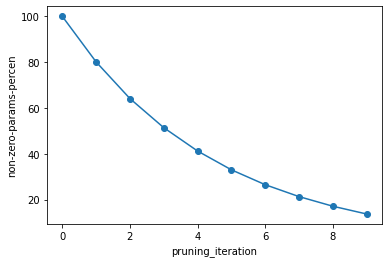

In [34]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(nonzero_param_percent,'-o')
ax.set_xlabel('pruning_iteration')
ax.set_ylabel('non-zero-params-percen')

In [35]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_10_0.001_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_10_0.001_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_per_iter:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])


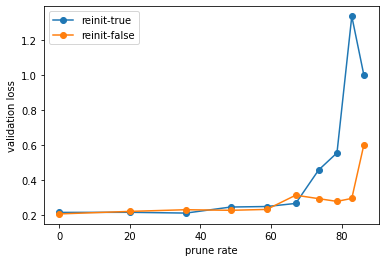

In [36]:
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true,'-o',label='reinit-true')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false,'-o',label='reinit-false')
ax.set_xlabel('prune rate')
ax.set_ylabel('validation loss')
ax.legend()

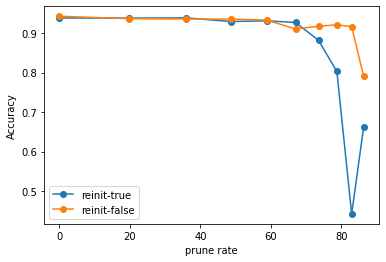

In [37]:
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinit-true')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='reinit-false')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

In [38]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_100_0.001_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_100_0.001_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_per_iter:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])


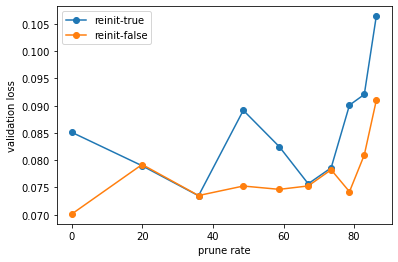

In [39]:
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_true,'-o',label='reinit-true')
ax.plot(100-np.array(nonzero_param_percent),finalValLoss_reinit_false,'-o',label='reinit-false')
ax.set_xlabel('prune rate')
ax.set_ylabel('validation loss')
ax.legend()

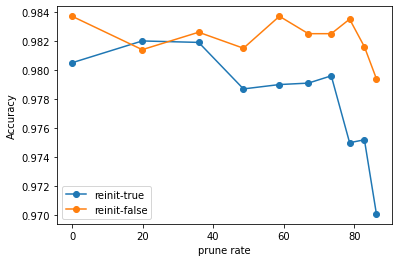

In [40]:
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinit-true')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='reinit-false')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()